# Solve Sudoku

In [195]:
TRAINING_IMAGES_FOLDER = "data/train/images/"
TRAINING_LABELS_PATH = "data/train/labels.csv"
TEST_IMAGES_FOLDER = "data/test/images"

### Import Libraries

In [196]:
import os
import tqdm

import pandas as pd
import numpy as np

import torch
import torchvision.transforms as transforms
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

import cv2 as cv

### Align Game Grid

In [197]:
def align_img(img):

    # Add border
    img = cv.copyMakeBorder(img, 50, 50, 50, 50, cv.BORDER_CONSTANT, value=(0, 0, 0))

    # Make gray
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply a blur to reduce noise
    blurred = cv.GaussianBlur(gray, (5, 5), 0)

    # Define a 3x3 Sobel filter for detecting horizontal and vertical edges
    edges = cv.Canny(blurred, 100, 200)

    # Find contours in the edge image
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Initialize min/max values
    min_xy, max_xy, min_yx, max_yx = float('inf'), 0, float('inf'), 0

    # Loop over all contours and their points
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if x + y < min_xy:
                top_left = (x, y)
                min_xy = x + y
            if x+y > max_xy:
                bottom_right = (x, y)
                max_xy = x+y
            if y-x < min_yx:
                top_right = (x, y)
                min_yx = y-x
            if x-y < max_yx:
                bottom_left = (x, y)
                max_yx = x-y

    border = np.array([top_left, bottom_left, bottom_right, top_right])

    # Draw the largest contour on the original image
    # cv.drawContours(img, [border], -1, (0, 255, 0), 3)

    # cv.drawMarker(img, bottom_left, color=(255,0,0))
    # cv.drawMarker(img, bottom_right, color=(255,0,0))
    # cv.drawMarker(img, top_right, color=(255,0,0))
    # cv.drawMarker(img, top_left, color=(255,0,0))
    # print(top_right)
    # print(top_left)
    # print(bottom_right)
    # print(bottom_left)


    # cv_imshow(img)

    # Get the minimum bounding rectangle of the border
    # rect = cv.minAreaRect(border)

    # # Calculate the rotation angle of the rectangle
    # angle = rect[2]
 
    # if angle > 0:
    #     border = np.array([top_left, bottom_left, bottom_right, top_right])
    # else:
    #     border = np.array([top_right, top_left, bottom_left, bottom_right])

    # # Apply a perspective transform to get a bird's-eye view of the grid
    src = np.float32(border)
    dst = np.float32([[0, 0], [0, 450], [450, 450], [450, 0]])
    M = cv.getPerspectiveTransform(src, dst)
    warped = cv.warpPerspective(gray, M, (450, 450))

    # cv_imshow(warped)
    
    return warped

### Read Digits

#### Model

The model was trained on the MNIST dataset for 20 epochs. Random noise was added to the training data.
It achieved accuracy of 97% on testing.

That accuracy can't be guaranteed on the application because the quality of the image on the application cannot be guaranteed to approximate the quality of the dataset.

In [198]:
from classifier.DigitClassifier import DigitClassifier
# Load Digit Classifier

# Instantiate model architecture
model = DigitClassifier()

# Load saved model weights
model.load_state_dict(torch.load('classifier\\digit_classifier_new_progresive49.pth'))
name = 'new_progresive49'

# Set model to evaluation mode
model.eval()

DigitClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### Image Manipulation

In [199]:
def detect_digit(square):
    '''
    Determines if there exists a digit in the square,
    uses an algorithmic approach, checks if any of the central 10x10
    pixels are not the color of the background 
    '''
    square = (square.numpy() * 255).astype(np.uint8).squeeze()
    ret, square = cv.threshold(square,150,255,cv.THRESH_BINARY)
    square = square[9:19, 9:19] #10x10 square w/out borders
    for i in range(8):
        for j in range(8):
            if (square[i][j]!=0):
                return True
    return False

In [200]:
def remove_grid(square):
    square = square.squeeze()
    th = (square.numpy() * 255).astype(np.uint8).squeeze()
    ret, th = cv.threshold(th,100,255,cv.THRESH_BINARY)
    th = th.astype(np.float32) / 255

    black = torch.min(square)

    erase_row = []
    erase_col = []

    # Iterate through the rows and check the sum
    for row in range(square.shape[0]):
        if sum(th[row, :]) >= 23:
            erase_row.append(row)

    # Iterate through the columns and check the sum
    for col in range(square.shape[1]):
        if sum(th[:, col]) >= 23:
            erase_col.append(erase_col)

    # Iterate through the rows and erase
    for row in range(square.shape[0]):
        if sum(th[row, :]) >= 23:
            square[row, :] = black

    # Iterate through the columns and erase
    for col in range(square.shape[1]):
        if sum(th[:, col]) >= 24:
            square[:, col] = black
    
    square = square.unsqueeze(0)
    return square
    

In [201]:
def extract_digits(img):

    transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
    ])

    img_digits = []
    digits = []
    for i in range(0, 450, 50):
        for j in range(0, 450, 50):
            img_digit = img[i:i+50, j:j+50]
            img_digit = -transform(Image.fromarray(img_digit)) + 1

            if detect_digit(img_digit):
                img_digit = remove_grid(img_digit)
                #thresholding
                #img_digit[img_digit < 0.5] = 0
                img_digit = (img_digit - torch.mean(img_digit)) / torch.std(img_digit)
                img_digits.append(img_digit)
                # plt.imshow(img_digit.squeeze(), cmap='gray')
                # plt.show()
                # break

                output = model(img_digit)
                
                digit = torch.argmax(output, dim=1).item()
                # print(f'digit: {digit}, confidence: {torch.max(torch.softmax(output, dim=1))}')
                digits.append(digit)             
            else:
                img_digits.append(img_digit)
                digits.append(0)

    digits = np.array(digits).reshape((9,9))

    return digits


### Sudoku Solver

In [202]:
from sudoku import Sudoku

#Solves row major form puzzles
def findSolution(game):
  puzzle = Sudoku(3, 3, board=game.reshape(9,9).tolist())
  solution = puzzle.solve()

  if solution.board[0][0] == None:
    return game

  solutionString = np.array(solution.board).reshape(81)

  return solutionString

### Putting It All Together

In [203]:
training_labels_df = pd.read_csv(TRAINING_LABELS_PATH)

X = []
y = []

for _idx, row in tqdm.tqdm(training_labels_df.iterrows(), total=training_labels_df.shape[0]):
    filepath = os.path.join(
        TRAINING_IMAGES_FOLDER,
        f"{row.id:04d}.png"
    )
    img = cv.imread(filepath)

    img_aligned = align_img(img)
    
    data_X = extract_digits(img_aligned)
    # convert to list of chars
    data_y = list(map(int, row.solution))
    
    X.extend(data_X)
    y.extend(data_y)

X = np.array(X)
y = np.array(y)

100%|██████████| 5000/5000 [09:01<00:00,  9.23it/s]


In [204]:
np.savetxt("games\\no_threshold49.csv", X, delimiter=",")

In [205]:
# X = np.genfromtxt('games\\all_games_progressive_noise_21.csv', delimiter=',').astype(int)
# y = np.genfromtxt('all_solutions.csv', delimiter=',').astype(int)

In [207]:
X = X.reshape(5000, 81)
y = y.reshape(5000, 81)

X_solved = []

for game in X.astype(int):
    X_solved.append(findSolution(game))

X_solved = np.array(X_solved)
X_solved_unfilled = X_solved.copy()


X_solved[X_solved == 0] = 5

# Calculate the MSE loss between x and y
loss = np.mean(np.square(X_solved - y))
loss_unfilled = np.mean(np.square(X_solved_unfilled - y))
print(loss)
print(loss_unfilled)

3.771562962962963
14.137562962962964


best result: 3.771562962962963

In [208]:
X_solved_filtered = X_solved_unfilled[X_solved_unfilled != 0]
y_filtered = y[X_solved_unfilled != 0]
accuracy_filtered = np.sum(X_solved_filtered == y_filtered) / len(X_solved_filtered)
print('Accuracy detected digits:', accuracy_filtered)

Accuracy detected digits: 0.8897843790877252


In [209]:
# Calculate accuracy
accuracy = np.sum(X_solved == y) / len(X_solved)
print('Accuracy:', accuracy)

Accuracy: 45.91


In [210]:
import pandas as pd
df = pd.DataFrame([[name, accuracy_filtered, accuracy, loss_unfilled, loss]], columns=['Approach', 'Accuracy Detection', 'Accuracy Solved', 'Loss Unfilled', 'Loss'])
df.to_csv('stats\\new_progresive49.csv')

Accuracy: 42.036

[[    0     0     0     0     0     0     0     0     0     0]
 [29986 13652     2     3     0     0     0  1357     0     0]
 [29618     0 14383   539     0     0     0   460     0     0]
 [29685    25    80 15195     0     0     0    14     1     0]
 [29551    14     0     0 15405     0    13    17     0     0]
 [29606     0     0    12     0 15364     0     2     5    11]
 [29550     1     0     0  1177   329 13188     1   459   295]
 [30525     0     0     0     0     0     0 14475     0     0]
 [29643     0    46     1    35     0    13     0 15073   189]
 [29738     0     0     9  1201     0     0     8    38 14006]]


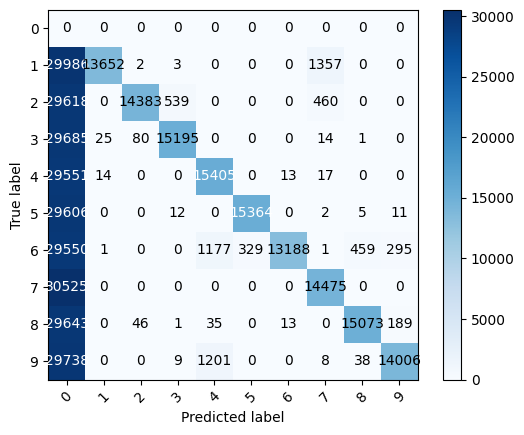

In [211]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Generate example data
y_true = y.flatten()
y_pred = X.flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set ticks and tick labels
ax.set_xticks(np.arange(len(np.unique(y_pred))))
ax.set_yticks(np.arange(len(np.unique(y_pred))))
ax.set_xticklabels(np.unique(y_pred))
ax.set_yticklabels(np.unique(y_pred))
ax.tick_params(axis='x', labelrotation=45)

# Add annotations
thresh = cm.max() / 2.0
for i in range(len(np.unique(y_pred))):
    for j in range(len(np.unique(y_pred))):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Set labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.savefig('stats\\cm_new_progresive49.png')

# Show plot
plt.show()